In [1]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
event = 'event000001000'

print('Loading event {}'.format(path+event))

hits, cells, particles, truth = load_event(path+event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/event000001000
event000001000 memory usage 18.46 MB


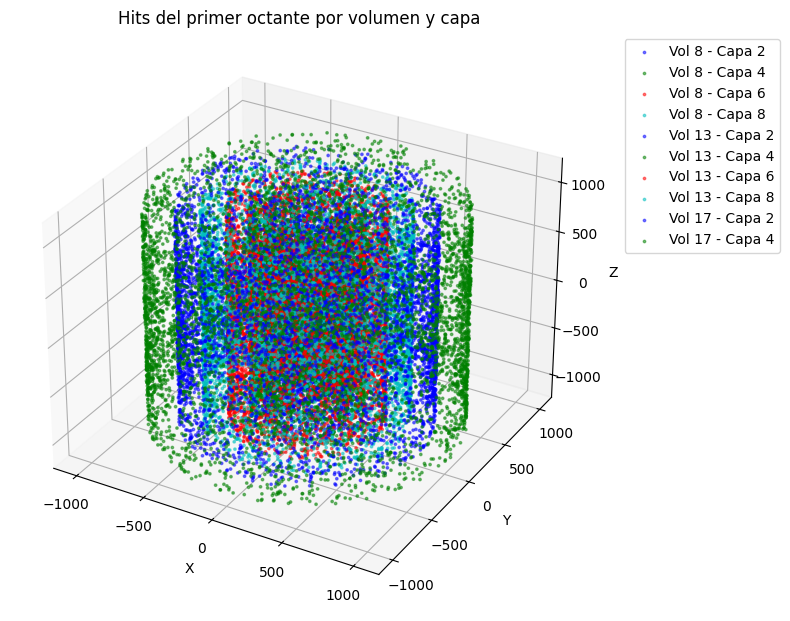

In [2]:
from kalman_filter import get_hits_dict

volume_ids = hits['volume_id'].unique()
volume_ids = volume_ids[[1, 4, 7]]  # Selección específica de volúmenes
first_volume = volume_ids[0]

hits_dict = get_hits_dict(hits, volume_ids, OCTANTE = False)
# Sacar los hits de hits_dict

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] 

for v_idx, volume_id in enumerate(hits_dict.keys()):
    subdict = hits_dict[volume_id]
    for l_idx, (layer_id, df) in enumerate(subdict.items()):
        color = colors[l_idx % len(colors)]
        ax.scatter(df['x'], df['y'], df['z'], s=3, alpha=0.5, 
                   label=f'Vol {volume_id} - Capa {layer_id}', c=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Hits del primer octante por volumen y capa')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## Buscamos triplets entre las tres primeras layers

In [3]:
#print(truth.head())
truth['p'] = np.sqrt(truth['tpx']**2 + truth['tpy']**2 + truth['tpz']**2)
high_momentum_particles = truth.groupby('particle_id')['p'].mean().sort_values(ascending=False)
N = 1000
selected_particles = high_momentum_particles.head(N).index  

# De particles, filtro por IDs seleccionados
particles_high_p = particles[particles['particle_id'].isin(selected_particles)]
print(particles.head())

        particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits  
0  -0.203492 -1      8  
1   2.010060  1     11  
2   0.683881 -1      0  
3   0.991616  1     12  
4 -39.824902  1      3  


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import random

class TripletBatchGenerator(Sequence):
    def __init__(self, hits_dict, truth, batch_size=32, max_triplets_per_batch=64):
        self.hits_dict = hits_dict
        self.truth = truth
        self.batch_size = batch_size
        self.max_triplets_per_batch = max_triplets_per_batch
        self.layers = [2, 4, 6]
        self.volume_id = list(hits_dict.keys())[0]  # Usa el primer volumen disponible

        # Hits por capa
        self.hits_by_layer = {
            layer: hits_dict[self.volume_id][layer][['x', 'y', 'z', 'particle_id']].dropna()
            for layer in self.layers
        }

        # Precalcula listas de hits
        self.hits_lists = [df.to_numpy() for df in self.hits_by_layer.values()]

    def __len__(self):
        return self.max_triplets_per_batch

    def __getitem__(self, idx):
        X_batch, y_batch = [], []
        n_positives = self.batch_size
        n_negatives = self.batch_size

        # Positivos: todos los hits con el mismo particle_id
        count = 0
        while count < n_positives:
            # Elige un `particle_id` que esté presente en las tres capas
            common_pids = set(self.hits_by_layer[self.layers[0]]['particle_id']) \
                        & set(self.hits_by_layer[self.layers[1]]['particle_id']) \
                        & set(self.hits_by_layer[self.layers[2]]['particle_id'])

            if not common_pids:
                break  

            pid = random.choice(list(common_pids))

            hits_triplet = []
            for i, layer in enumerate(self.layers):
                layer_hits = self.hits_by_layer[layer]
                hits = layer_hits[layer_hits['particle_id'] == pid]
                if hits.empty:
                    break
                hit = hits.sample(1).iloc[0]
                hits_triplet.append(hit[['x', 'y', 'z']].to_numpy())
            
            if len(hits_triplet) == 3:
                triplet = np.concatenate(hits_triplet)
                X_batch.append(triplet)
                y_batch.append(1)
                count += 1

        # Negativos: hits con distinto particle_id
        count = 0
        while count < n_negatives:
            hits_triplet = []
            pids = []
            for i in range(3):
                hit = random.choice(self.hits_lists[i])
                hits_triplet.append(hit[:3])
                pids.append(hit[3])
            
            # Asegúrate de que no todos los pids son iguales
            if len(set(pids)) > 1:
                triplet = np.concatenate(hits_triplet)
                X_batch.append(triplet)
                y_batch.append(0)
                count += 1

        # Mezcla aleatoriamente positivos y negativos
        X_batch = np.array(X_batch, dtype=np.float32)
        y_batch = np.array(y_batch, dtype=np.float32)

        # Mezclar
        indices = np.random.permutation(len(X_batch))
        return X_batch[indices], y_batch[indices]


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

hits_with_pid = hits.merge(truth[['hit_id', 'particle_id', 'tpx', 'tpy', 'tpz']], on='hit_id', how='left')
ml_hits_dict = get_hits_dict(hits_with_pid, volume_ids, OCTANTE=True)

generator = TripletBatchGenerator(ml_hits_dict, truth, batch_size=32)
X_batch, y_batch = generator[0]

print("X shape:", X_batch.shape)  # Debe ser (batch_size, 9)
print("y shape:", y_batch.shape)  # Debe ser (batch_size,)
print("X dtype:", X_batch.dtype)

model = Sequential([
    Dense(64, activation='relu', input_shape=(9,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(generator, epochs=10)


X shape: (64, 9)
y shape: (64,)
X dtype: float32


/mnt_pool/c3_users/user/uo290313/Desktop/TFG/repositorioTFG/myenv/lib64/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/mnt_pool/c3_users/user/uo290313/Desktop/TFG/repositorioTFG/myenv/lib64/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.7077 - loss: 2.6778
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9506 - loss: 0.1584
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9690 - loss: 0.1250
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9638 - loss: 0.1113
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9759 - loss: 0.0913
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9762 - loss: 0.0957
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9769 - loss: 0.0934
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9829 - loss: 0.0666
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9811 - loss: 0.0666
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9715 - loss: 0.0978


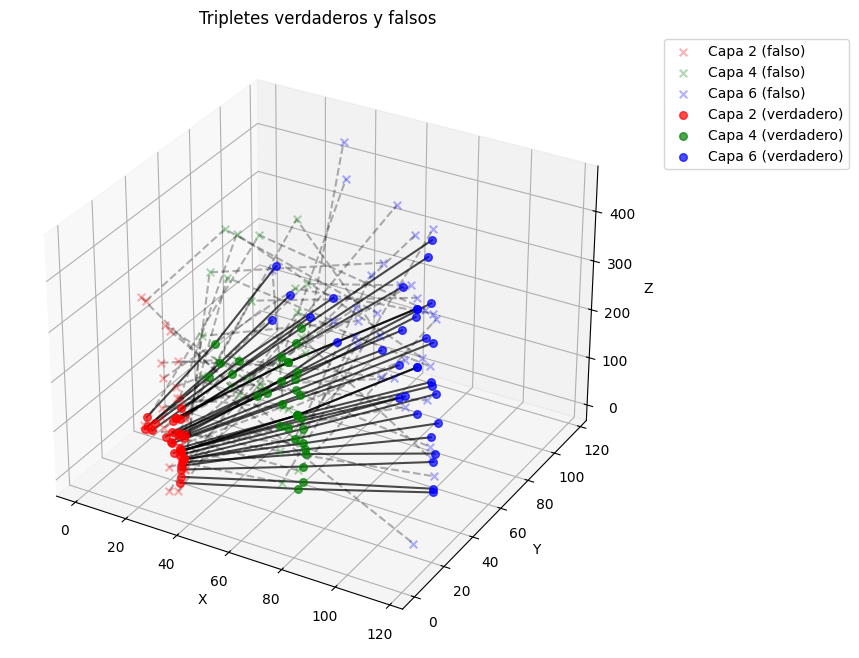

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_triplets(X_batch, y_batch):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['r', 'g', 'b']  # capas 2,4,6
    labels = [f'Capa {2 + i*2}' for i in range(3)]
    plotted_labels_true = [False]*3
    plotted_labels_false = [False]*3

    for triplet, label in zip(X_batch, y_batch):
        points = triplet.reshape(3, 3)
        if label == 1:  # verdadero
            line_style = '-'
            alpha = 0.7
            marker_style = 'o'
        else:  # falso
            line_style = '--'
            alpha = 0.3
            marker_style = 'x'

        for i in range(3):
            if label == 1 and not plotted_labels_true[i]:
                ax.scatter(points[i, 0], points[i, 1], points[i, 2], c=colors[i], s=30, alpha=alpha,
                           marker=marker_style, label=f'{labels[i]} (verdadero)')
                plotted_labels_true[i] = True
            elif label == 0 and not plotted_labels_false[i]:
                ax.scatter(points[i, 0], points[i, 1], points[i, 2], c=colors[i], s=30, alpha=alpha,
                           marker=marker_style, label=f'{labels[i]} (falso)')
                plotted_labels_false[i] = True
            else:
                ax.scatter(points[i, 0], points[i, 1], points[i, 2], c=colors[i], s=30, alpha=alpha, marker=marker_style)

        ax.plot(points[:, 0], points[:, 1], points[:, 2], c='k', linestyle=line_style, alpha=alpha)

    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Tripletes verdaderos y falsos')
    ax.grid(True)
    plt.show()


plot_triplets(X_batch, y_batch)  